/home/atruergod/Python/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:23:48 - cmdstanpy - INFO - compiling stan file /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/chap05/exercise/model5-3.stan to exe file /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/chap05/exercise/model5-3


✅ Stan 모델 파일 생성 완료

--- (1) 원본 모델 실행 및 Python에서 잔차(epsilon) 계산 ---


09:24:05 - cmdstanpy - INFO - compiled model executable: /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/chap05/exercise/model5-3
09:24:05 - cmdstanpy - INFO - CmdStan start processing
09:24:05 - cmdstanpy - INFO - Chain [1] start processing
09:24:05 - cmdstanpy - INFO - Chain [2] start processing
09:24:05 - cmdstanpy - INFO - Chain [3] start processing
09:24:05 - cmdstanpy - INFO - Chain [4] start processing
09:24:05 - cmdstanpy - INFO - Chain [3] done processing
09:24:05 - cmdstanpy - INFO - Chain [4] done processing
09:24:05 - cmdstanpy - INFO - Chain [1] done processing
09:24:05 - cmdstanpy - INFO - Chain [2] done processing
09:24:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model5-3.stan', line 16, column 8 to column 40)
Consider re-running with show_console=True if the above output is unclear!
09:24:05 - cmdstanpy - INFO - compiling stan file /home/atruerg

Python 계산 잔차(평균) 예시 (앞 5개): [-0.0931  0.0964  0.066   0.1989  0.0833]

--- (2) 수정된 모델(Generated Quantities) 실행 ---


09:24:20 - cmdstanpy - INFO - compiled model executable: /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/chap05/exercise/model5-3_resid
09:24:20 - cmdstanpy - INFO - CmdStan start processing
09:24:20 - cmdstanpy - INFO - Chain [1] start processing
09:24:20 - cmdstanpy - INFO - Chain [2] start processing
09:24:20 - cmdstanpy - INFO - Chain [3] start processing
09:24:20 - cmdstanpy - INFO - Chain [4] start processing
09:24:20 - cmdstanpy - INFO - Chain [1] done processing
09:24:20 - cmdstanpy - INFO - Chain [3] done processing
09:24:20 - cmdstanpy - INFO - Chain [2] done processing
09:24:20 - cmdstanpy - INFO - Chain [4] done processing
09:24:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model5-3_resid.stan', line 16, column 8 to column 40)
Consider re-running with show_console=True if the above output is unclear!


Stan 계산 잔차(평균) 예시 (앞 5개):   [-0.0931  0.0964  0.066   0.1989  0.0833]


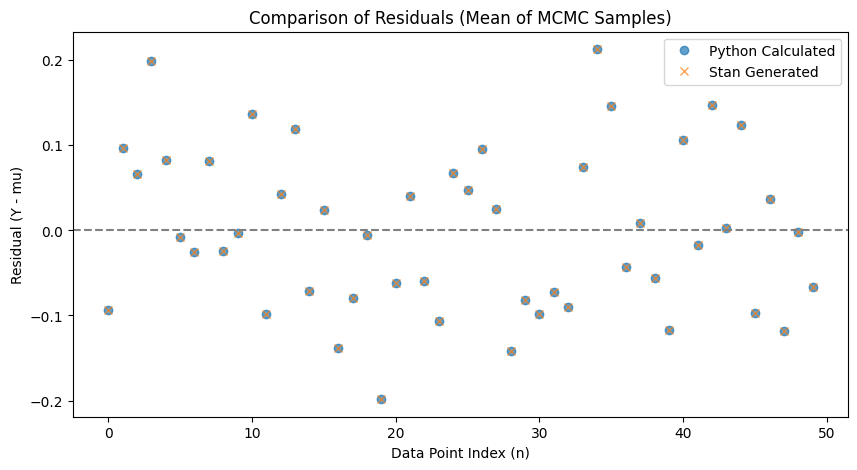

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import os

# -----------------------------------------------------------------------------
# 설정: 파일 경로
# -----------------------------------------------------------------------------
BASE_DIR = os.getcwd()
STAN_FILE_ORIGINAL = os.path.join(BASE_DIR, 'model5-3.stan')
STAN_FILE_MODIFIED = os.path.join(BASE_DIR, 'model5-3_resid.stan')

# -----------------------------------------------------------------------------
# 1. Stan 모델 파일 생성
# -----------------------------------------------------------------------------
def create_stan_files():
    # (Original) 사용자가 제공한 원본 코드
    # Y가 0~1 사이의 값으로 제한된 데이터라고 가정하고 있습니다.
    code_original = """
    data {
        int N;
        vector<lower=0, upper=1>[N] Sex;
        vector<lower=0>[N] Income;
        vector<lower=0, upper=1>[N] Y; 
    }
    parameters {
        vector[3] b;
        real<lower=0> sigma;
    }
    transformed parameters {
        vector[N] mu = b[1] + b[2]*Sex[1:N] + b[3]*Income[1:N];
    }
    model {
        Y[1:N] ~ normal(mu[1:N], sigma);
    }
    generated quantities {
        array[N] real yp = normal_rng(mu[1:N], sigma);
    }
    """

    # (Modified) (2)번 문항: epsilon(잔차)을 Stan 내부에서 계산하는 코드
    # generated quantities 블록에 epsilon 계산이 추가되었습니다.
    code_modified = """
    data {
        int N;
        vector<lower=0, upper=1>[N] Sex;
        vector<lower=0>[N] Income;
        vector<lower=0, upper=1>[N] Y;
    }
    parameters {
        vector[3] b;
        real<lower=0> sigma;
    }
    transformed parameters {
        vector[N] mu = b[1] + b[2]*Sex[1:N] + b[3]*Income[1:N];
    }
    model {
        Y[1:N] ~ normal(mu[1:N], sigma);
    }
    generated quantities {
        array[N] real yp = normal_rng(mu[1:N], sigma);
        
        // --- [추가된 부분] ---
        // 잔차(epsilon) = 관측값(Y) - 추정된 평균(mu)
        vector[N] epsilon;
        epsilon = Y - mu;
    }
    """

    with open(STAN_FILE_ORIGINAL, 'w') as f:
        f.write(code_original)
    with open(STAN_FILE_MODIFIED, 'w') as f:
        f.write(code_modified)
    print("✅ Stan 모델 파일 생성 완료")

# -----------------------------------------------------------------------------
# 2. 가상의 데이터 생성 (Model Formula에 맞춤)
# -----------------------------------------------------------------------------
def generate_data(N=50, seed=123):
    np.random.seed(seed)
    
    # Sex: 0 또는 1
    Sex = np.random.randint(0, 2, N).astype(float)
    
    # Income: 양수값 (예: LogNormal 분포)
    Income = np.random.lognormal(0, 0.5, N)
    Income = Income / Income.max() # 0~1 사이로 정규화 (Y 범위 고려)
    
    # True Parameters
    b_true = [0.3, 0.1, 0.4] # 절편, 성별계수, 소득계수
    sigma_true = 0.1
    
    # Mu 계산
    mu_true = b_true[0] + b_true[1]*Sex + b_true[2]*Income
    
    # Y 생성 (0~1 사이 제약조건을 만족하도록 클리핑)
    Y = np.random.normal(mu_true, sigma_true)
    Y = np.clip(Y, 0.01, 0.99) # Stan의 data constraints <lower=0, upper=1> 준수
    
    return {'N': N, 'Sex': Sex, 'Income': Income, 'Y': Y}

# -----------------------------------------------------------------------------
# 메인 실행 함수
# -----------------------------------------------------------------------------
def main():
    create_stan_files()
    stan_data = generate_data()
    
    # ---------------------------------------------------------
    # (1) Python에서 잔차 계산하기
    # ---------------------------------------------------------
    print("\n--- (1) 원본 모델 실행 및 Python에서 잔차(epsilon) 계산 ---")
    model_orig = CmdStanModel(stan_file=STAN_FILE_ORIGINAL)
    fit_orig = model_orig.sample(data=stan_data, 
                                 iter_sampling=1000, iter_warmup=1000, 
                                 chains=4, seed=123, show_progress=False)
    
    # MCMC 샘플 추출 (DataFrame)
    # mu는 transformed parameters에 있으므로 draws_pd()로 가져올 수 있습니다.
    draws_orig = fit_orig.draws_pd()
    
    # mu 샘플들만 추출 (컬럼 이름이 usually 'mu[1]', 'mu[2]'... 형태임)
    # N개의 데이터 포인트 각각에 대한 mu 샘플을 가져옵니다.
    N = stan_data['N']
    Y_obs = stan_data['Y'] # 실제 관측 데이터 (길이 N)
    
    # 잔차를 저장할 리스트
    residuals_python = []
    
    # 각 데이터 포인트 n에 대해 반복
    for n in range(1, N + 1):
        mu_col = f'mu[{n}]'
        mu_samples = draws_orig[mu_col] # n번째 데이터에 대한 mu의 MCMC 샘플들 (4000개)
        
        # 잔차 계산: epsilon[n] = Y[n] - mu_samples
        # Y[n]은 스칼라(고정값), mu_samples는 벡터(확률분포)
        epsilon_n = Y_obs[n-1] - mu_samples
        residuals_python.append(epsilon_n.mean()) # 확인용으로 평균만 저장
        
    print(f"Python 계산 잔차(평균) 예시 (앞 5개): {np.round(residuals_python[:5], 4)}")

    # ---------------------------------------------------------
    # (2) Stan 내부에서 잔차 생성하기
    # ---------------------------------------------------------
    print("\n--- (2) 수정된 모델(Generated Quantities) 실행 ---")
    model_mod = CmdStanModel(stan_file=STAN_FILE_MODIFIED)
    fit_mod = model_mod.sample(data=stan_data, 
                               iter_sampling=1000, iter_warmup=1000, 
                               chains=4, seed=123, show_progress=False)
    
    # Stan에서 계산된 epsilon 추출
    draws_mod = fit_mod.draws_pd()
    
    # Stan이 계산한 epsilon의 평균 확인
    residuals_stan = []
    for n in range(1, N + 1):
        eps_col = f'epsilon[{n}]'
        residuals_stan.append(draws_mod[eps_col].mean())
        
    print(f"Stan 계산 잔차(평균) 예시 (앞 5개):   {np.round(residuals_stan[:5], 4)}")
    
    # ---------------------------------------------------------
    # 결과 비교 시각화
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(residuals_python, 'o', label='Python Calculated', alpha=0.7)
    plt.plot(residuals_stan, 'x', label='Stan Generated', alpha=0.7)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Comparison of Residuals (Mean of MCMC Samples)")
    plt.xlabel("Data Point Index (n)")
    plt.ylabel("Residual (Y - mu)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()